# LIME explanations

In [1]:
import trustyai
import os

trustyai.init()

## Simple example

We start by defining our black-box model, typically represented by

$$
f(\mathbf{x}) = \mathbf{y}
$$

Where $\mathbf{x}=\{x_1, x_2, \dots,x_m\}$ and $\mathbf{y}=\{y_1, y_2, \dots,y_n\}$.

Our example toy model, in this case, takes an all-numerical input $\mathbf{x}$ and return a $\mathbf{y}$ of either `true` or `false` if the sum of the $\mathbf{x}$ components is within a threshold $\epsilon$ of a point $\mathbf{C}$, that is:

$$
f(\mathbf{x}, \epsilon, \mathbf{C})=\begin{cases}
\text{true},\qquad \text{if}\ \mathbf{C}-\epsilon<\sum_{i=1}^m x_i <\mathbf{C}+\epsilon \\
\text{false},\qquad \text{otherwise}
\end{cases}
$$

This model is provided in the `TestUtils` module. We instantiate with a $\mathbf{C}=500$ and $\epsilon=1.0$.

In [2]:
from trustyai.utils import TestUtils

center = 10.0
epsilon = 2.0

model = TestUtils.getSumThresholdModel(center, epsilon)

Next we need to define a **goal**.
If our model is $f(\mathbf{x'})=\mathbf{y'}$ we are then defining our $\mathbf{y'}$ and the counterfactual result will be the $\mathbf{x'}$ which satisfies $f(\mathbf{x'})=\mathbf{y'}$.

We will define our goal as `true`, that is, the sum is withing the vicinity of a (to be defined) point $\mathbf{C}$. The goal is a list of `Output` which take the following parameters

- The feature name
- The feature type
- The feature value (wrapped in `Value`)
- A confidence threshold, which we will leave at zero (no threshold)

In [3]:
from trustyai.model import output

decision = "inside"
goal = [output(name=decision, dtype="bool", value=True, score=0.0)]

We will now define our initial features, $\mathbf{x}$. Each feature can be instantiated by using `FeatureFactory` and in this case we want to use numerical features, so we'll use `FeatureFactory.newNumericalFeature`.

In [4]:
import random
from trustyai.model import feature

features = [feature(name=f"x{i+1}", dtype="number", value=random.random()*10.0) for i in range(3)]

As we can see, the sum of of the features will not be within $\epsilon$ (1.0) of $\mathbf{C}$ (500.0). As such the model prediction will be `false`:

In [5]:
feature_sum = 0.0
for f in features:
    value = f.value.as_number()
    print(f"Feature {f.name} has value {value}")
    feature_sum += value
print(f"\nFeatures sum is {feature_sum}")

Feature x1 has value 0.9504190093208076
Feature x2 has value 2.7346634858140995
Feature x3 has value 2.4023531768149784

Features sum is 6.087435671949885


We execute the model on the generated input and collect the output

In [6]:
from org.kie.kogito.explainability.model import PredictionInput, PredictionOutput

goals = model.predictAsync([PredictionInput(features)]).get()

We wrap these quantities in a `SimplePrediction`:

In [7]:
from trustyai.local.counterfactual import simple_prediction


prediction = simple_prediction(input_features=features, outputs=goals[0].outputs)

We can now instantiate the **explainer** itself.


In [8]:
from trustyai.explainers import LimeExplainer

explainer = LimeExplainer(samples=10)

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


We generate the **explanation** as a _dict : decision --> saliency_.


In [9]:
explanation = explainer.explain(prediction, model)

We inspect the saliency scores assigned by LIME to each feature

In [10]:
print(explanation.show(decision))

Saliencies for 'inside':
	x1: -0.15857229655759178
	x2: 0.511017963061179
	x3: -0.17077846639495745



We generate the saliency graph with the builtin method `plot(decision)`:

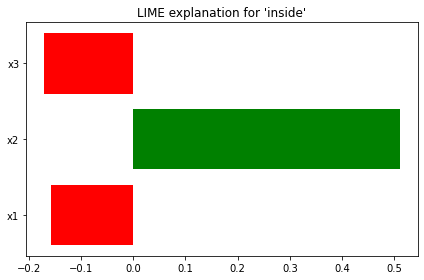

In [11]:
explanation.plot(decision)

## Using Python models



We will now show how to use a custom Python model with TrustyAI LIME implementation.

The model will be an XGBoost one trained with the `credit-bias` dataset.

For convenience, the model is pre-trained and serialised with `joblib` so that for this example we simply need to deserialised it.

In [12]:
import joblib

xg_model = joblib.load("models/credit-bias-xgboost.joblib")
print(xg_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.9861206227457426,
              seed=27, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)


This model has as a single **output** a boolean `PaidLoan`, which will predict whether a certain loan applicant will repay the loan in time or not. The model is slightly more complex than the previous examples, with **input** features:

|Input feature         | Type    | Note        |
|----------------------|---------|-------------|
|`NewCreditCustomer`   |boolean  ||
|`Amount`              |numerical||
|`Interest`            |numerical||
|`LoanDuration`        |numerical|In months|
|`Education`           |numerical|Level (1, 2, 3..)|
|`NrOfDependants`      |numerical|Integer|
|`EmploymentDurationCurrentEmployer`|numerical|Integer (years)|
|`IncomeFromPrincipalEmployer`|numerical||
|`IncomeFromPension`   |numerical||
|`IncomeFromFamilyAllowance`|numerical||
|`IncomeFromSocialWelfare`|numerical||
|`IncomeFromLeavePay`|numerical||
|`IncomeFromChildSupport`|numerical||
|`IncomeOther`|numerical||
|`ExistingLiabilities`|numerical|integer|
|`RefinanceLiabilities`|numerical|integer|
|`DebtToIncome`|numerical||
|`FreeCash`|numerical||
|`CreditScoreEeMini`|numerical|integer|
|`NoOfPreviousLoansBeforeLoan`|numerical|integer|
|`AmountOfPreviousLoansBeforeLoan`|numerical||
|`PreviousRepaymentsBeforeLoan`|numerical||
|`PreviousEarlyRepaymentsBefoleLoan`|numerical||
|`PreviousEarlyRepaymentsCountBeforeLoan`|numerical|integer|
|`Council_house`|boolean||
|`Homeless`|boolean||
|`Joint_ownership`|boolean||
|`Joint_tenant`|boolean||
|`Living_with_parents`|boolean||
|`Mortgage`|boolean||
|`Other`|boolean||
|`Owner`|boolean||
|`Owner_with_encumbrance`|boolean||
|`Tenant`|boolean||
|`Entrepreneur`|boolean||
|`Fully`|boolean||
|`Partially`|boolean||
|`Retiree`|boolean||
|`Self_employed`|boolean||

We will start by testing the model with an input we are quite sure (from the original data) that will be predicted as `false`:

In [13]:
x = [[False,2125.0,20.97,60,4.0,0.0,6.0,0.0,301.0,0.0,53.0,0.0,0.0,0.0,8,6,26.29,10.92,1000.0,1.0,500.0,590.95,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0]]

We can see that this application will be rejected with a probability of $\sim77\%$:

In [14]:
import numpy as np

print(xg_model.predict_proba(np.array(x)))
print(f"Paid loan is predicted as: {xg_model.predict(np.array(x))}")

[[0.7770493  0.22295067]]
Paid loan is predicted as: [False]


We will now prepare the XGBoost model to be used from the TrustyAI counterfactual engine.

To do so, we simply need to first create a prediction function which takes:

- A list of `PredictionInput` as inputs
- A list of `PredictionOutput` as outputs

If these two conditions are met, the actual inner working of this method can be anything (including calling a XGBoost Python model for prediction as in our case):

In [15]:
from org.kie.kogito.explainability.model import PredictionInput, PredictionOutput

def predict(inputs):
    values = [_feature.value.as_obj() for _feature in inputs[0].features]
    result = xg_model.predict_proba(np.array([values]))
    false_prob, true_prob = result[0]
    if false_prob > true_prob:
        _prediction = (False, false_prob)
    else:
        _prediction = (True, true_prob)
    _output = output(name="PaidLoan", dtype="bool", value=_prediction[0], score=_prediction[1])
    return [PredictionOutput([_output])]

Once the prediction method is created, we wrap in a `PredictionProvider` class.

This class takes care of all the JVM's asynchronous plumbing for us.

In [16]:
from trustyai.model import Model

cb_model = Model(predict)

We will now express the previous inputs (`x`) in terms of `Feature`s, so that we might use it for the counterfactual search:

In [17]:
def make_feature(name, _value):
    if isinstance(_value, bool):
        return feature(name=name, dtype="bool", value=_value)
    else:
        return feature(name=name, dtype="number", value=_value)

features = [make_feature(p[0], p[1]) for p in [("NewCreditCustomer", False),
        ("Amount", 2125.0),
        ("Interest", 20.97),
        ("LoanDuration", 60.0),
        ("Education", 4.0),
        ("NrOfDependants", 0.0),
        ("EmploymentDurationCurrentEmployer", 6.0),
        ("IncomeFromPrincipalEmployer", 0.0),
        ("IncomeFromPension", 301.0),
        ("IncomeFromFamilyAllowance", 0.0),
        ("IncomeFromSocialWelfare", 53.0),
        ("IncomeFromLeavePay", 0.0),
        ("IncomeFromChildSupport", 0.0),
        ("IncomeOther", 0.0),
        ("ExistingLiabilities", 8.0),
        ("RefinanceLiabilities", 6.0),
        ("DebtToIncome", 26.29),
        ("FreeCash", 10.92),
        ("CreditScoreEeMini", 1000.0),
        ("NoOfPreviousLoansBeforeLoan", 1.0),
        ("AmountOfPreviousLoansBeforeLoan", 500.0),
        ("PreviousRepaymentsBeforeLoan", 590.95),
        ("PreviousEarlyRepaymentsBefoleLoan", 0.0),
        ("PreviousEarlyRepaymentsCountBeforeLoan", 0.0),
        ("Council_house", False),
        ("Homeless", False),
        ("Joint_ownership", False),
        ("Joint_tenant", False),
        ("Living_with_parents", False),
        ("Mortgage", False),
        ("Other", False),
        ("Owner", False),
        ("Owner_with_encumbrance", True),
        ("Tenant", True),
        ("Entrepreneur", False),
        ("Fully", False),
        ("Partially", False),
        ("Retiree", True),
        ("Self_employed", False)]]

We can confirm now, with the newly created `PredictionProvider` model that this input will lead to a `false` `PaidLoan` prediction:

In [18]:
prediction = cb_model.predictAsync([PredictionInput(features)]).get()
prediction[0].outputs[0].toString()

'Output{value=false, type=boolean, score=0.7835956811904907, name='PaidLoan'}'

We generate a prediction to be passed to the LIME explainer

In [19]:
prediction_obj = simple_prediction(input_features=features, outputs=prediction[0].outputs)

We execute the LIME explainer on the XGBoost model and prediction

In [93]:
cb_explainer = LimeExplainer(samples=len(features)*25, perturbations=1, seed=23, normalise_weights=True)
cb_explanation = cb_explainer.explain(prediction_obj, cb_model)

We output the top 2 most important features for the prediction outcome

In [94]:
for f in cb_explanation.map()['PaidLoan'].getTopFeatures(2):
    print(f)

FeatureImportance{feature=Feature{name='NewCreditCustomer', type=boolean, value=false}, score=0.9998912987399108, confidence= +/-0.0}
FeatureImportance{feature=Feature{name='Amount', type=number, value=2125.0}, score=0.9998912987399108, confidence= +/-0.0}


In [95]:
print(cb_explanation.show('PaidLoan'))

Saliencies for 'PaidLoan':
	NewCreditCustomer: 0.9998912987399108
	Amount: 0.9998912987399108
	Interest: 0.9998912987399108
	LoanDuration: 0.9998912987399108
	Education: 0.9998912987399108
	NrOfDependants: 0.9998912987399108
	EmploymentDurationCurrentEmployer: 0.9998912987399108
	IncomeFromPrincipalEmployer: 0.9998912987399108
	IncomeFromPension: 0.9998912987399108
	IncomeFromFamilyAllowance: 0.9998912987399108
	IncomeFromSocialWelfare: 0.9998912987399108
	IncomeFromLeavePay: 0.9998912987399108
	IncomeFromChildSupport: 0.9998912987399108
	IncomeOther: 0.9998912987399108
	ExistingLiabilities: 0.9998912987399108
	RefinanceLiabilities: 0.9998912987399108
	DebtToIncome: 0.9998912987399108
	FreeCash: 0.9998912987399108
	CreditScoreEeMini: 0.9998912987399108
	NoOfPreviousLoansBeforeLoan: 0.9998912987399108
	AmountOfPreviousLoansBeforeLoan: 0.9998912987399108
	PreviousRepaymentsBeforeLoan: 0.9998912987399108
	PreviousEarlyRepaymentsBefoleLoan: 0.9998912987399108
	PreviousEarlyRepaymentsCountB

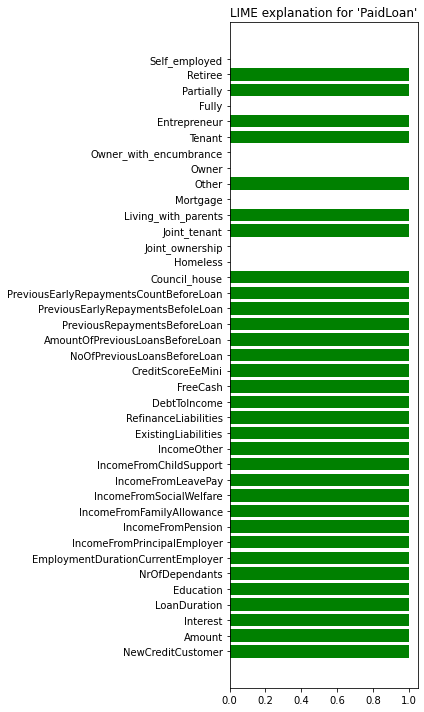

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,10))
cb_explanation.plot('PaidLoan')